# Let's start with Multimodal Deep Archetypal Analysis 

### Archetypal Analysis

Archetypal Analysis is a technique in statistics and machine learning designed to uncover the extreme points within a dataset, termed archetypes. These archetypes represent the most distinct or extreme manifestations within the data space, suggesting that every data point can be approximated as a mixture of these archetypal forms. 
Given a dataset represented by the matrix $X$, where each row corresponds to a d-dimensional data point, the objective of archetypal analysis is to identify a matrix $A$, which encapsulates the archetypes, and a matrix $B$, which contains coefficients that express each data point in $X$ as convex combinations of the archetypes in $A$.

The core optimization challenge in archetypal analysis is to minimize the reconstruction error between the dataset $X$ and its approximation $ABX$, formally expressed as:
$$
\min_{A, B} \|X - ABX\|^2_F
$$ 

subject to constraints for both $A$ and $B$ that ensure the convexity of the combinations, with $B_{ij} \geq 0$ for all elements to guarantee non-negativity, and $\sum_{j} B_{ij} = 1$ for all $i$, ensuring that the coefficients for each data point sum to one. 
Similarly, constraints are applied to $A$ to ensure its columns can be interpreted as mixtures of data points, hence $A_{ij} \geq 0$ and $\sum_{j} A_{ij} = 1$ for all $i$. 
These constraints ensure that each data point in $X$ is represented as a convex combination of archetypes, making the solution interpretable and reflective of the underlying structure of the dataset.



The original algorithm proposed by  is based on the idea of solving alternating interative least square problems. Namely, the algorithm operates iteratively, alternating between two main steps: updating coefficients B for a fixed set of archetypes $A$, and then updating $A$ given $B$. Initially, $A$ is populated with randomly selected data points. In each iteration, $B$ is updated to represent each data point as a convex combination of the current archetypes, and then $A$ is updated to better fit the data points based on the new coefficients. The process iterates until the change in $A$ between iterations, measured using the Frobenius norm $\|A_{new} - A_{old}\|_F$, falls below a predefined convergence threshold, or a maximum number of iterations is reached.

Let us first define some convenience function:

In [ ]:
# Some code was taken/adapted from the amazing implementation in
# https://github.com/aleixalcacer/archetypes

import numpy as np
from scipy.optimize import nnls


def frobenius_norm_difference(M1, M2):
    """Compute the Frobenius norm of the difference between two matrices."""
    return np.linalg.norm(M1 - M2, 'fro')

def initialize_archetypes(X, k):
    """Randomly initialize archetypes."""
    
    # For A and B we just sample from a dirichlet distribution
    B = np.random.dirichlet(np.ones(X.shape[0]), k)
    A = np.random.dirichlet(np.ones(k), X.shape[0])
    
    return A, B

def optimize_nnls(M1,M2):
    
    # Add some constants to enforce the convexity of the final matrix
    M1 = np.pad(M1, ((0, 0), (0, 1)), "constant", constant_values=20)
    M2 = np.pad(M2, ((0, 0), (0, 1)), "constant", constant_values=20)
    res = np.empty((M1.shape[0], M2.shape[0]))
    
    # Solve the actual non-negative least square problem
    for j in range(res.T.shape[1]):
        res.T[:, j], _ = nnls(M2.T, M1.T[:, j])
    
    # Check convexity + remove nans
    res /= res.sum(1)[:, None]
    res[np.isnan(res)] = 1 / res.shape[1]
    return res

def update_archetypes(X, H):
    """Update archetypes Z for fixed coefficients."""
    return optimize_nnls(H,X)

def update_weights(X, H):
    """Update coefficients A for fixed archetypes"""
    return  optimize_nnls(X,H)

We then run the training loop and have a look at the results. For this example we choose a toy dataset of body measuremnts for 3 different species of penguins.

In [1]:
# code a function that performs archetypal analysis
def archetypal_analysis(X, k, max_iter=30, tol=1e-3):
    """Perform archetypal analysis."""
    A, B = initialize_archetypes(X, k)
    H = B @ X
    loss_old = None
    for _ in range(max_iter):
        A = update_weights(X, H)
        H = np.linalg.pinv(A) @ X
        B = update_archetypes(X, H)
        H = B @ X
        loss = frobenius_norm_difference(X, A @ H)
        if loss_old is not None and loss_old - loss < tol:
            break
    return A, B

ERROR: Error in parse(text = x, srcfile = src): <text>:2:5: unexpected symbol
1: # code a function that performs archetypal analysis
2: def archetypal_analysis
       ^


In [ ]:
import seaborn as sns

penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We will work with just 2 dimensions as it's easier to understand what is happening, but of course AA can be extended to inputs of arbitraty dimensions.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

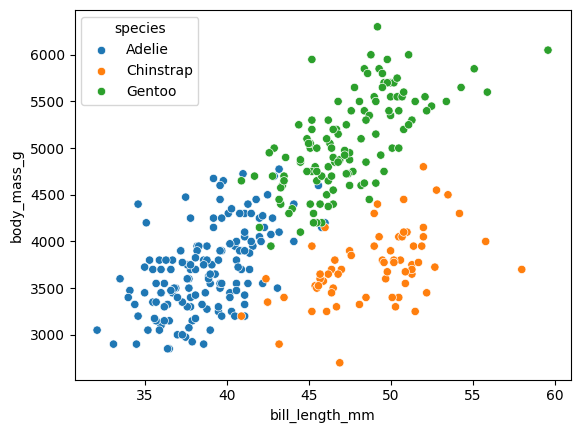

In [ ]:

penguins =  penguins[~penguins['body_mass_g'].isna()]

sns.scatterplot(data=penguins, x="bill_length_mm", y="body_mass_g", hue="species")


In [ ]:
# We standardize as it improves stability of the algorithm

X_df = penguins[["bill_length_mm", "body_mass_g"]]
X_df = (X_df-X_df.mean())/X_df.std()
X = X_df.values

A,B = archetypal_analysis(X,3, max_iter = 10)



<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

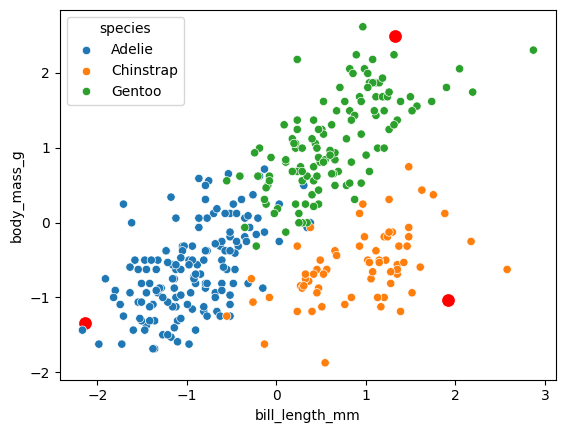

In [ ]:
# Generate the archetypes
H = B @ X

X_df["species"] = penguins["species"]

# plot the archetypes together to this scatterplot in the same plots, and connect them by a triangle
sns.scatterplot(x=H[:,0], y=H[:,1], color='red', s=100)
sns.scatterplot(data=X_df, x="bill_length_mm", y="body_mass_g", hue="species")


As you can see the algorithm correctly fits a trangle across the 2D space of the data. The archetypes are the red points and the data points are colored by species. To give a bit of interpretation we have small penguins with a short bill, which are mainly represented by Adelie specie. Another archetype has low body mass and a long bill, while the last one his a big penguin with a somewhat long bill. The main point of archetypal analysis is that it gives us the possibility to reason continously by comparison to some extreme prototypes. It gives us a different look on our data compared to clustering and works very well when we have some continous process (be it differentiation or fitness optimization) underlying our data.

### Why deep archetypal analysis? 

There are two main reasons why we would like to move from the standard analysis we saw before:
*   Better scaling properties 
*   Working in non-linear latent space

Let's briefly talk about them before looking at an implementation. Regarding the scaling behaviour of the classical algorithm we presented before, it is wuite clear how it becomes quite slow for big input matrices as solving the non-negative least squares becomes expensive. Improvements on that have been proposed, like the use of the Frank-Wolf algorithm. Despite this, the idea of being able to express matrices A and B as a function of the input and the ability to optimize using classical SGD is certainly appealing for large datasets. Another important point is the space where to perform the AA. In our toy dataset we had only two features but of course in reality it commonly happens to work in very large spaces. What you tend to do is first perform dimensionality reduction for example with a PCA and then run the AA on the loadings of the PCA. Of course, real dataset can be very complicated and the idea of being able to use neural networks to both reduce the dimensionality in a non-linear way becomes a key component to get good results in real case scenarios. These two ideas converge in attempts to extend AA into the Deep Learning framework as in . 


In [ ]:
import daario as daa

### DAARIO: the model